# Amazon Fine Food Reviews Analysis:

# T-SNE Visualization of Amazon reviews with polarity based color-coding


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## 1.Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).
<br>Vectorized the reviews using Bow, TF-IDF, Avg-W2Vec, TF-IDF-W2Vec and visualize the positive and negative reviews using t-SNE plot

[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## 1.1 Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 2. Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID 
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 3. Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'wouldn', 'no', 'at', "you'll", 'between', 'that', 'am', 'but', 'hadn', 'themselves', 'has', 'when', 'shan', 'only', "shan't", 'those', 'or', 'over', "you're", 'where', 'to', "didn't", 'whom', 'aren', 'both', 'again', 'such', 'mightn', 'ma', 'itself', 'them', "should've", "doesn't", "mustn't", "wouldn't", 'then', 'yours', 'of', 'doesn', 'its', "she's", "haven't", 'her', 'yourselves', "shouldn't", 'against', 'too', 'being', 'a', 'why', 'own', 'herself', 'these', 'because', 'more', 'who', 'most', 'now', "isn't", 'ain', 'd', 'off', 'before', 'i', 'were', 'been', 'below', 'into', 'after', 'mustn', 'don', 'above', 'not', 'so', 'had', 'for', 't', 'o', "needn't", 'until', 'by', "won't", 'you', 'couldn', 'your', "you'd", "it's", 'can', 'our', 'there', 'himself', 'are', 'through', 'down', 'further', "that'll", 'same', 'needn', "wasn't", 'up', 'as', 'with', 'wasn', 'weren', 'very', "aren't", 'in', 'on', 'ourselves', 'my', "you've", 'it', 'than', 'y', 'm', 'any', 'yourself', "hadn't", 'which', "

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower()))     #.encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = ' '.join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final_string[1]

'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open'

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
#final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('./final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [16]:
final.head(5) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [17]:
# We will collect different 2000 rows without repetition.
my_data = final[:2000]
print(my_data.shape)
my_data.head()

(2000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 4. Techniques For Vectorization

## 4.1 Bag of Words (BOW)

In [18]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(my_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 6858)
the number of unique words  6858


In [19]:
# converting sparse matrix to dense matrix
data_2000 = final_counts.todense()
labels_2000 = my_data["Score"]

## 4.1.2 Standardizing Data

In [20]:
from sklearn.preprocessing import StandardScaler
data_2000 = StandardScaler().fit_transform(data_2000)
print(data_2000.shape)

(2000, 6858)


## 4.2 t-SNE visualization of positive/negative reviews for Bag of Words (BOW) with different Perplexitys

TSNE:- It is brilliant idea to visualize high dimensional data The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms.
Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50.

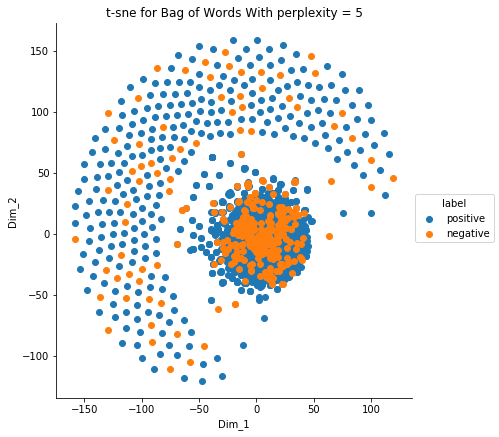

In [21]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=5,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 5')
plt.show()

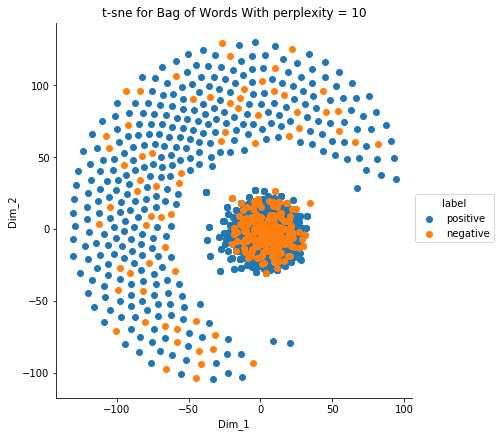

In [22]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 10')
plt.show()

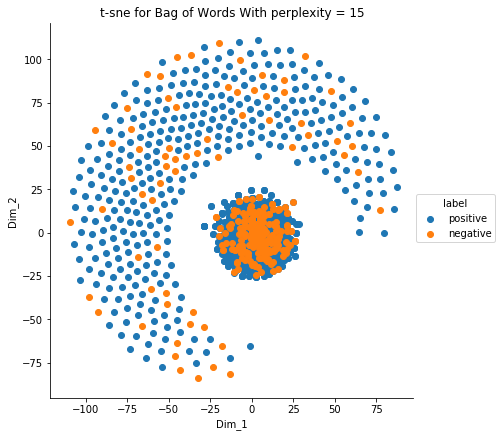

In [23]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=15,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 15')
plt.show()

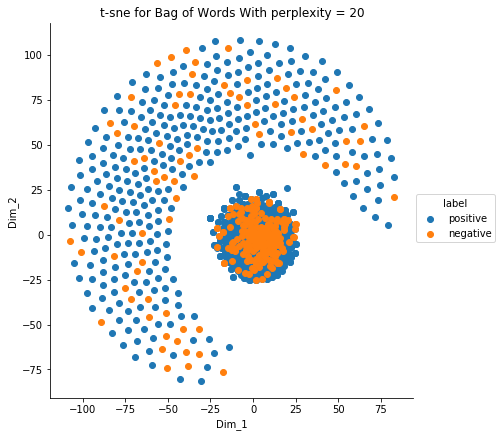

In [24]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=20,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 20')
plt.show()

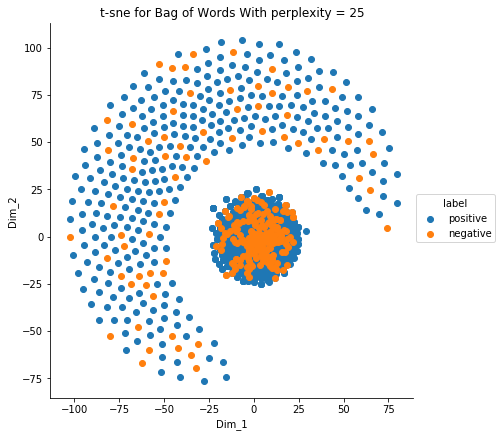

In [25]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 25')
plt.show()

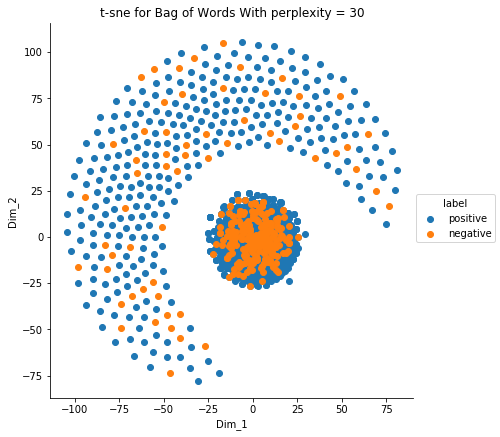

In [26]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 30')
plt.show()

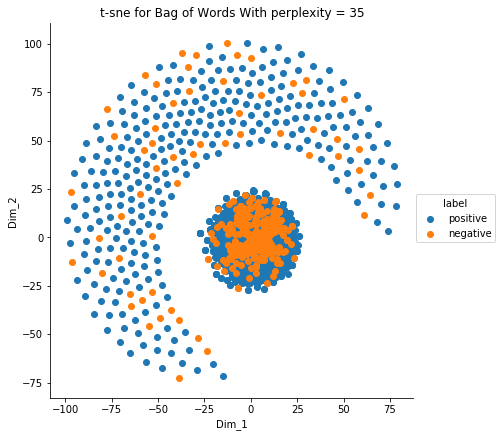

In [27]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=35,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 35')
plt.show()

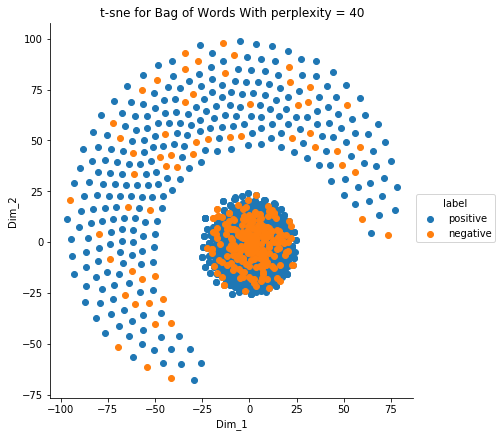

In [28]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=40,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 40')
plt.show()

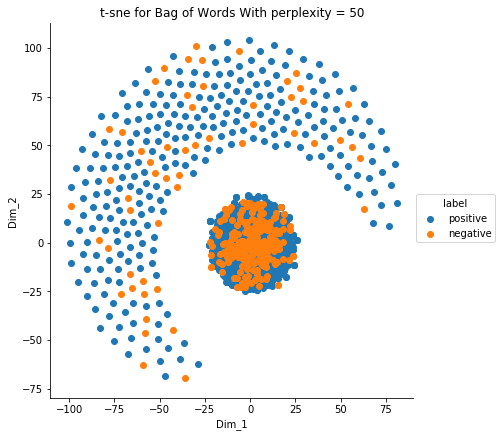

In [29]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Bag of Words With perplexity = 50')
plt.show()

Observation:-

1) With perplexity 5,10,15 i can well seperate positive and negative points compared to 25,40,50.

2) The reason i am not choosing perplexity 25,40,50 is overlapping is lot i cannot seperate positive and negative points.

# 5. TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(my_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 6858)
the number of unique words including both unigrams and bigrams  6858


In [31]:
# converting sparse matrix to dense matrix
data_2000 = final_tf_idf.todense()
labels_2000 = my_data["Score"]

## 5.1 Standardizing Data

In [32]:
from sklearn.preprocessing import StandardScaler
data_2000 = StandardScaler().fit_transform(data_2000)
print(data_2000.shape)

(2000, 6858)


## 5.2 t-SNE visualization of positive/negative reviews for TF-IDF

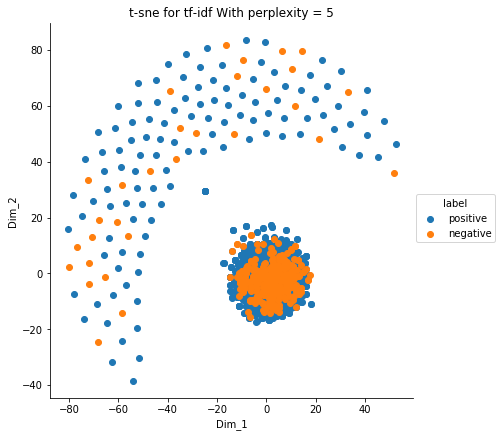

In [33]:
model = TSNE(n_components=2, random_state=0,perplexity=5,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 5')
plt.show()

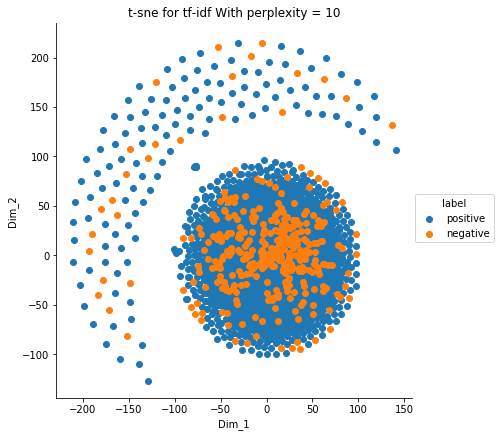

In [34]:
model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 10')
plt.show()

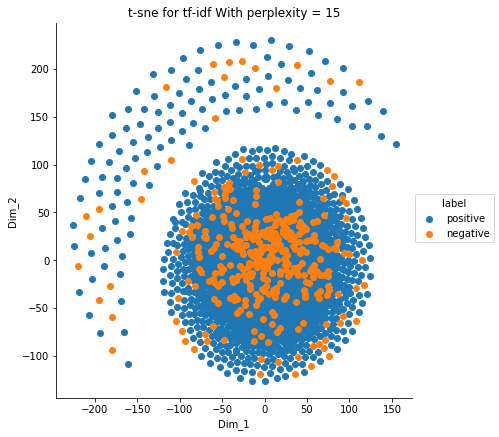

In [35]:
model = TSNE(n_components=2, random_state=0,perplexity=15,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 15')
plt.show()

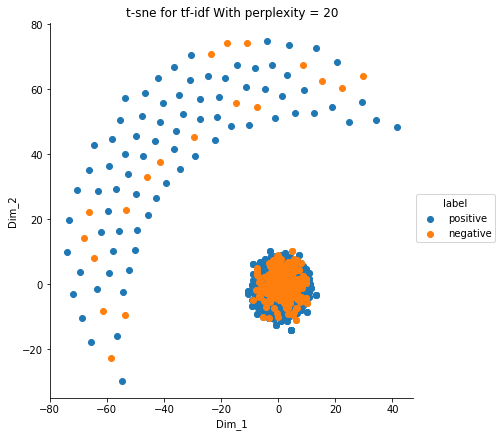

In [36]:
model = TSNE(n_components=2, random_state=0,perplexity=20,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 20')
plt.show()

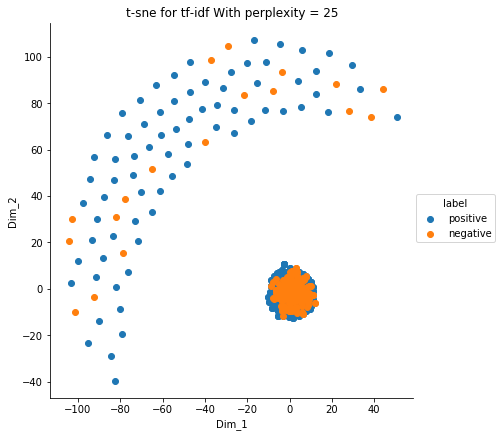

In [37]:
model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 25')
plt.show()

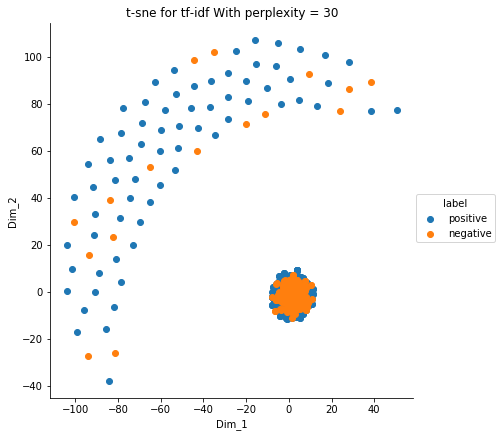

In [38]:
model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 30')
plt.show()

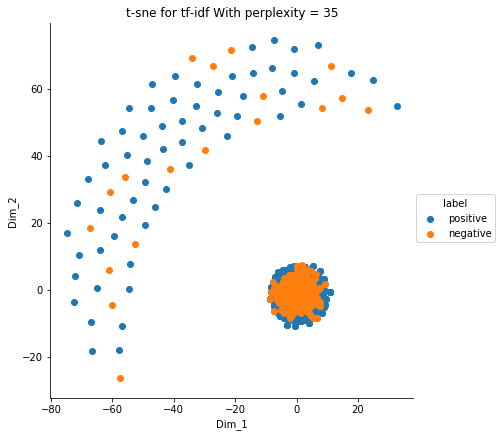

In [39]:
model = TSNE(n_components=2, random_state=0,perplexity=35,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 35')
plt.show()

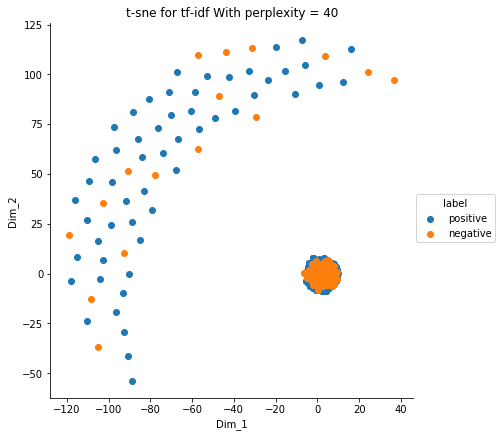

In [40]:
model = TSNE(n_components=2, random_state=0,perplexity=40,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 40')
plt.show()

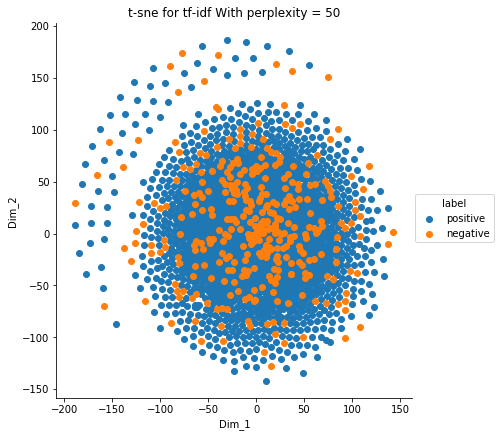

In [41]:
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for tf-idf With perplexity = 50')
plt.show()

Observation:-

1)With low perplexity values maximum positive and negative points lie one side  and otherside i can easily seperate them.

2)Overlapping is very less with low perplexity values.


# 6. Word2Vec

In [42]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in my_data['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [43]:
import gensim
model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)  
print(type(model))

<class 'gensim.models.word2vec.Word2Vec'>


In [44]:
words = list(model.wv.vocab)
print(len(words))
print(model)

2292
Word2Vec(vocab=2292, size=50, alpha=0.025)


In [45]:
model.wv.most_similar('book')

[('clear', 0.9997630715370178),
 ('consid', 0.9997572898864746),
 ('person', 0.9997518062591553),
 ('includ', 0.9997426271438599),
 ('abl', 0.999736487865448),
 ('must', 0.9997363090515137),
 ('may', 0.9997265338897705),
 ('version', 0.9997228384017944),
 ('end', 0.9997216463088989),
 ('white', 0.9997202157974243)]

# 7. Avg W2V

In [46]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


In [47]:
# converting sparse matrix to dense matrix
data_2000 = sent_vectors
labels_2000 = my_data["Score"]

## 7.1 Standardizing Data

In [48]:
from sklearn.preprocessing import StandardScaler
data_2000 = StandardScaler().fit_transform(data_2000)
print(data_2000.shape)

(2000, 50)


## 7.2 t-SNE visualization of positive/negative reviews for Avg W2V

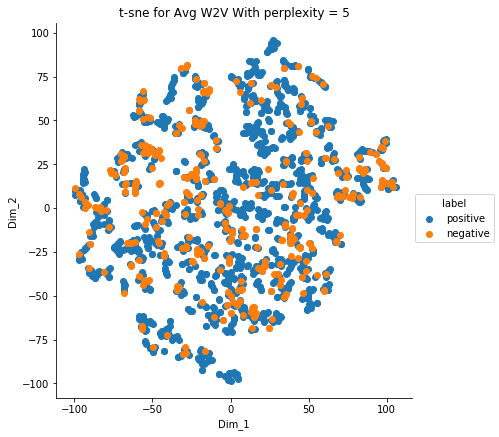

In [49]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=5,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 5')
plt.show()

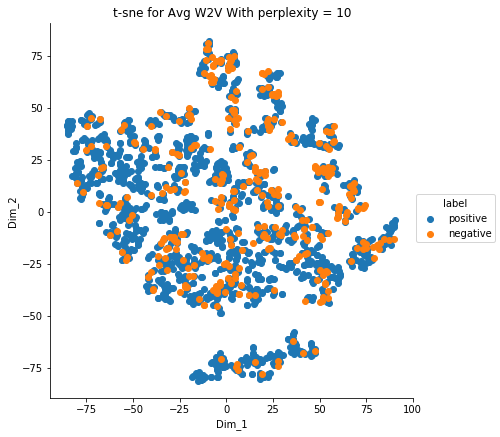

In [50]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 10')
plt.show()

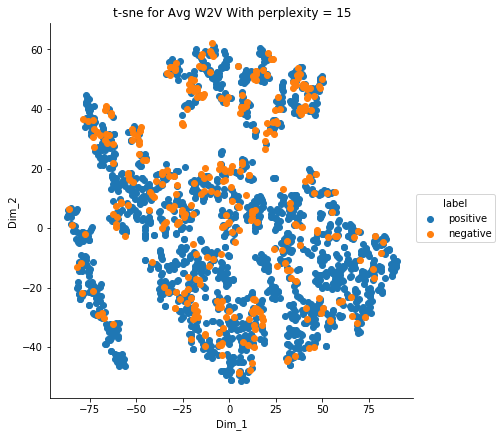

In [51]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=15,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 15')
plt.show()

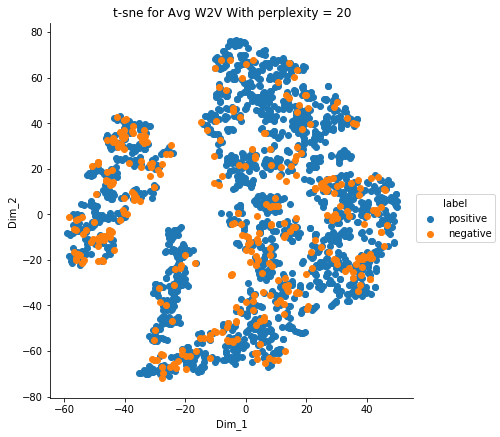

In [52]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=20,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 20')
plt.show()

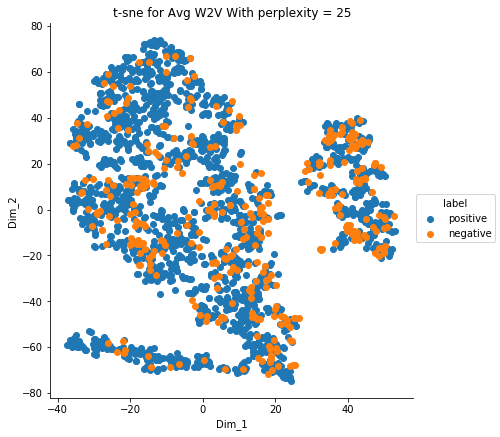

In [53]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 25')
plt.show()

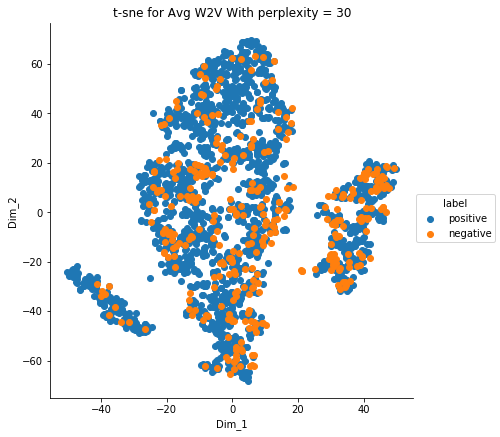

In [54]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 30')
plt.show()

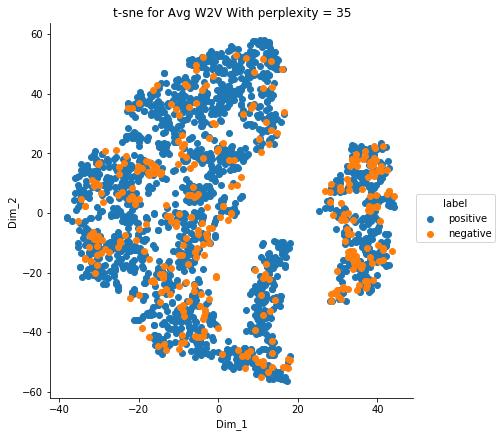

In [55]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=35,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 35')
plt.show()

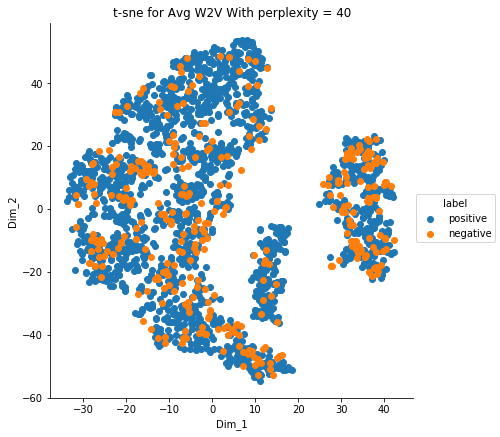

In [56]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=40,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 40')
plt.show()

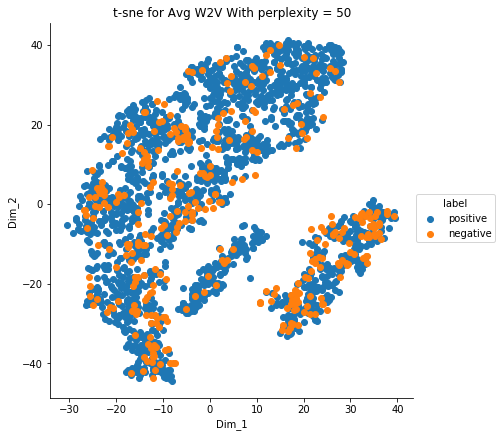

In [57]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for Avg W2V With perplexity = 50')
plt.show()

Observation:-


1) In Avgw2vec with perplexitys high i can easily seperate points compared to low perplexitys


## 8. TFIDF-W2V

In [58]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent:# for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [59]:
np.isnan(tfidf_sent_vectors)
tfidf_sent_vectors=np.nan_to_num(tfidf_sent_vectors)

In [60]:
# converting sparse matrix to dense matrix
data_2000 = tfidf_sent_vectors
labels_2000 = my_data["Score"]

In [61]:
from sklearn.preprocessing import StandardScaler
data_2000 = StandardScaler().fit_transform(data_2000)
print(data_2000.shape)

(2000, 50)


## 8.2 t-SNE visualization of positive/negative reviews for TFIDF-W2V

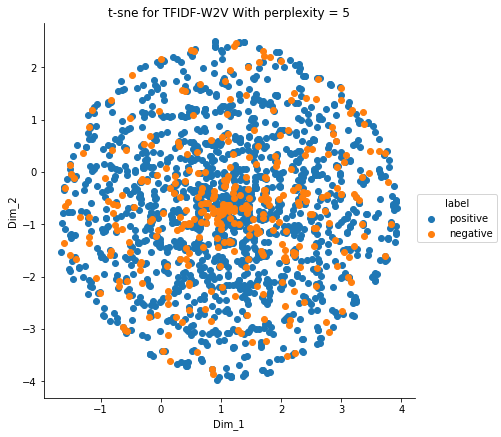

In [62]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=5,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 5')
plt.show()

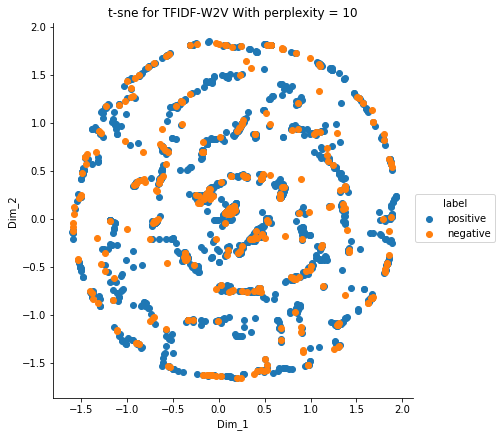

In [63]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 10')
plt.show()

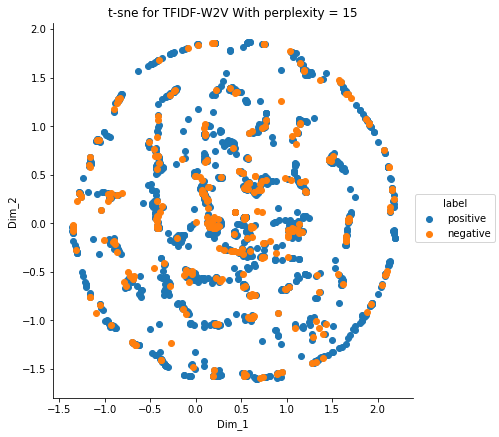

In [64]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=15,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 15')
plt.show()

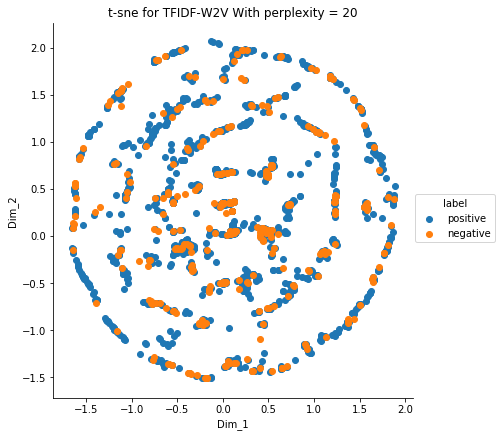

In [65]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=20,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 20')
plt.show()

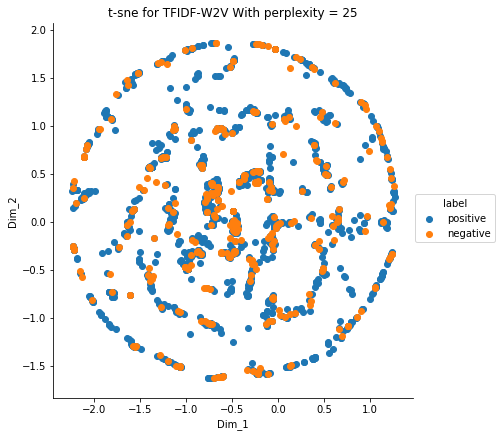

In [66]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 25')
plt.show()

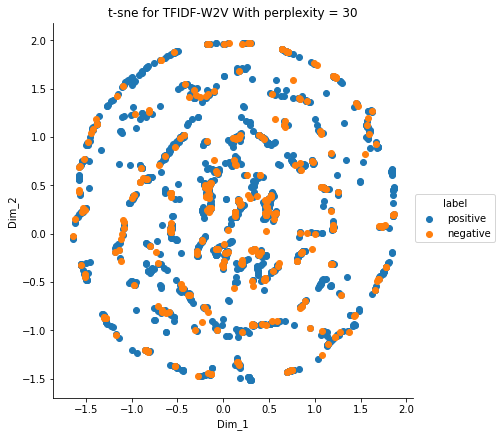

In [67]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T     
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 30')
plt.show()

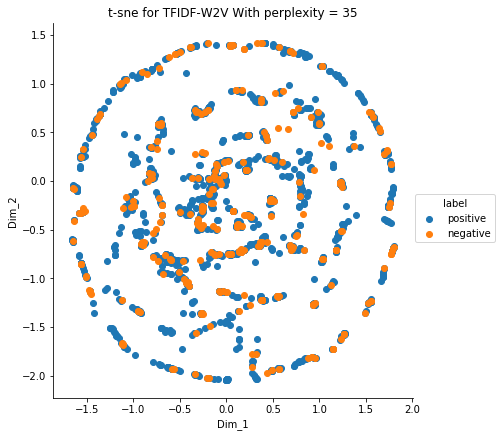

In [68]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=35,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T     
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 35')
plt.show()

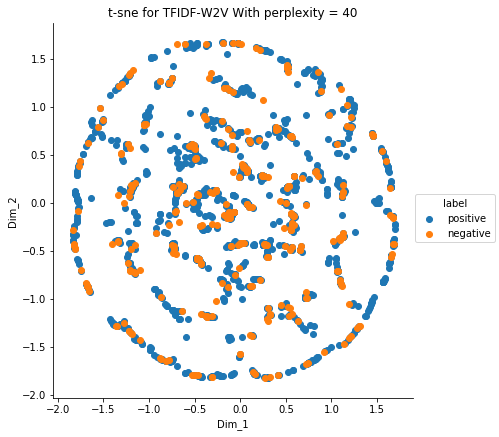

In [69]:
TSNE_model = TSNE(n_components=2, random_state=0,perplexity=40,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T     
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 40')
plt.show()

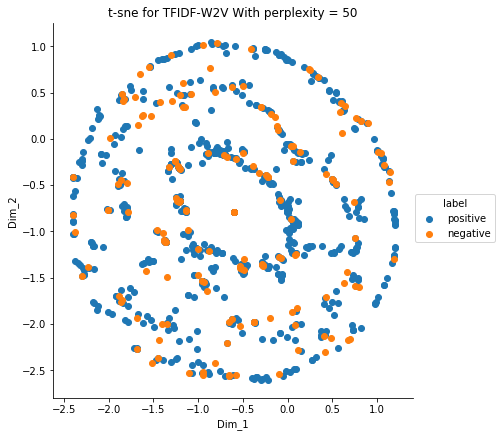

In [70]:
# TSNE

from sklearn.manifold import TSNE
import seaborn as sn

# Picking the top 1000 points as TSNE takes a lot of time for 364K points
data_1000 = tfidf_sent_vectors[0:1000]
labels_1000 = final["Score"][0:1000]

TSNE_model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = TSNE_model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T     
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-sne for TFIDF-W2V With perplexity = 50')
plt.show()

Observation:-

1) With perplexitys 5 and 50 i can easily seperate points.

# Conclusion:

t-distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly 

well suited for the visualization of high-dimensional datasets.

t-sne algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the 

probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the 

conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their 

probability density under a Gaussian (normal distribution) centered at A.

t-sne tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and 

lower-dimensional space for a perfect representation of data points in lower-dimensional space.

1) In bag of words  With low perplexitys i can easily seperate positive and negative points

2) In Avgw2vec With high perplexitys i can easily seperate positive and negative points

3) In TF-IDF with perplexitys 5 and 50 i can easily seperate positive and negative points

In all the techniques the negative points are overlapping on positive points.

The t-SNE is unable to distinguish the positive and negative points and the points are similar with a few of the points.

So we have to choose perplexitys where we can seperate maximum number of positive and negative points. we use different vectorization models.By t-sne visualization with different perplexity we would know range of points 

Steps Involved:-
1) Connecting SQL file

2) Data Cleaning Deduplication

3) Text Preprocessing

4) store final table into an SQlLite table for future.

4) Random sampling Taking 1st 2K Rows (Due to low Ram)

5) Applying Techniques for Vectorization like (Bow,tfidf,word2vec,Avgword2vec,Tfidfword2vec)

6) Converting sparse matrix to dense matrix

7) Standardizing Data

8) Applying t-sne with different perplexities 

9) Conclusion

The t-SNE is unable to distinguish the positive and negative points and the points are similar with a few of the points. So, There is no huge distance between the points.

So, t-SNE for Amazon Fine food reviews dataset doesn't have much information to classify the polarity of the reviews.
we cannot seperate points exactly
